# Import modules

In [9]:
#from keras.preprocessing.text import text_to_word_sequence
from plotly.express import histogram
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import seaborn as sns
import pandas as pd
import numpy as np
import math

# Open dataset

In [15]:
df = pd.read_csv('netflix_titles.csv')
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


### Info per atributte

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


### Name atributtes

In [6]:
df.columns

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description'],
      dtype='object')

## Type

### plot type

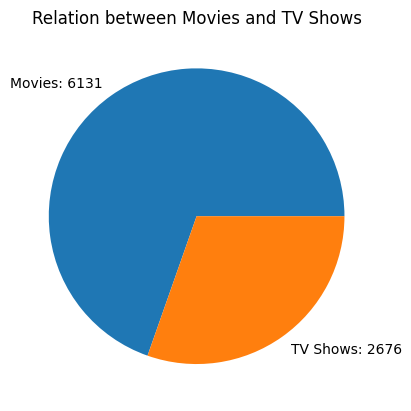

In [7]:
type_ = df['type'].value_counts()
plt.pie(type_, labels = ['Movies: ' + str(type_[0]),
                         'TV Shows: ' + str(type_[1])])
plt.title('Relation between Movies and TV Shows')
plt.show()

## Director

In [8]:
director = df['director'].value_counts()
director

Rajiv Chilaka                     19
Raúl Campos, Jan Suter            18
Marcus Raboy                      16
Suhas Kadav                       16
Jay Karas                         14
                                  ..
Raymie Muzquiz, Stu Livingston     1
Joe Menendez                       1
Eric Bross                         1
Will Eisenberg                     1
Mozez Singh                        1
Name: director, Length: 4528, dtype: int64

### plot directors

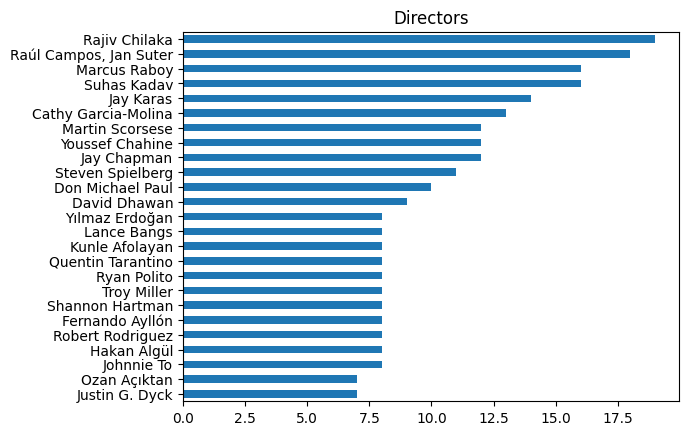

In [9]:
director[:25].plot(x = 'director', y = '', kind = 'barh', title='Directors').invert_yaxis()
plt.show()

## Cast

In [10]:
cast = df['cast']
cast

0                                                     NaN
1       Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...
2       Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...
3                                                     NaN
4       Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...
                              ...                        
8802    Mark Ruffalo, Jake Gyllenhaal, Robert Downey J...
8803                                                  NaN
8804    Jesse Eisenberg, Woody Harrelson, Emma Stone, ...
8805    Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...
8806    Vicky Kaushal, Sarah-Jane Dias, Raaghav Chanan...
Name: cast, Length: 8807, dtype: object

In [11]:
cast = [c.split(',') for c in cast if isinstance(c, str)]
cast[:2]

[['Ama Qamata',
  ' Khosi Ngema',
  ' Gail Mabalane',
  ' Thabang Molaba',
  ' Dillon Windvogel',
  ' Natasha Thahane',
  ' Arno Greeff',
  ' Xolile Tshabalala',
  ' Getmore Sithole',
  ' Cindy Mahlangu',
  ' Ryle De Morny',
  ' Greteli Fincham',
  ' Sello Maake Ka-Ncube',
  ' Odwa Gwanya',
  ' Mekaila Mathys',
  ' Sandi Schultz',
  ' Duane Williams',
  ' Shamilla Miller',
  ' Patrick Mofokeng'],
 ['Sami Bouajila',
  ' Tracy Gotoas',
  ' Samuel Jouy',
  ' Nabiha Akkari',
  ' Sofia Lesaffre',
  ' Salim Kechiouche',
  ' Noureddine Farihi',
  ' Geert Van Rampelberg',
  ' Bakary Diombera']]

In [12]:
merged_cast = []
for c in cast:
  merged_cast.extend(c)
merged_cast[:28]

['Ama Qamata',
 ' Khosi Ngema',
 ' Gail Mabalane',
 ' Thabang Molaba',
 ' Dillon Windvogel',
 ' Natasha Thahane',
 ' Arno Greeff',
 ' Xolile Tshabalala',
 ' Getmore Sithole',
 ' Cindy Mahlangu',
 ' Ryle De Morny',
 ' Greteli Fincham',
 ' Sello Maake Ka-Ncube',
 ' Odwa Gwanya',
 ' Mekaila Mathys',
 ' Sandi Schultz',
 ' Duane Williams',
 ' Shamilla Miller',
 ' Patrick Mofokeng',
 'Sami Bouajila',
 ' Tracy Gotoas',
 ' Samuel Jouy',
 ' Nabiha Akkari',
 ' Sofia Lesaffre',
 ' Salim Kechiouche',
 ' Noureddine Farihi',
 ' Geert Van Rampelberg',
 ' Bakary Diombera']

### plot cast

In [13]:
from plotly.express import histogram

fig = histogram(merged_cast).update_xaxes(categoryorder='total descending')
fig.update_layout(title = 'Cast Histogram')
fig.update_layout(title='Cast count', xaxis_title='Artist', yaxis_title='Count')
fig.update_layout(xaxis_tickangle=-45)
fig.show()

## Country

In [14]:
df['country'].value_counts()

United States                             2818
India                                      972
United Kingdom                             419
Japan                                      245
South Korea                                199
                                          ... 
Romania, Bulgaria, Hungary                   1
Uruguay, Guatemala                           1
France, Senegal, Belgium                     1
Mexico, United States, Spain, Colombia       1
United Arab Emirates, Jordan                 1
Name: country, Length: 748, dtype: int64

In [15]:
country = df['country']
country = [c.split(',') for c in country if isinstance(c, str)]

In [16]:
countrys = []
for c in country:
  countrys.extend(c)
for i in range(len(countrys)):
    countrys[i] = countrys[i].replace(' ', '')

In [17]:
counts_countrys = Counter(countrys)
counts_countrys

Counter({'UnitedStates': 3690,
         'SouthAfrica': 62,
         'India': 1046,
         'Ghana': 5,
         'BurkinaFaso': 1,
         'UnitedKingdom': 806,
         'Germany': 226,
         'Ethiopia': 1,
         'CzechRepublic': 22,
         'Mexico': 169,
         'Turkey': 113,
         'Australia': 160,
         'France': 393,
         'Finland': 11,
         'China': 162,
         'Canada': 445,
         'Japan': 318,
         'Nigeria': 103,
         'Spain': 232,
         'Belgium': 90,
         'SouthKorea': 231,
         'Singapore': 41,
         'Italy': 100,
         'Romania': 14,
         'Argentina': 91,
         'Venezuela': 4,
         'HongKong': 105,
         'Russia': 27,
         '': 7,
         'Ireland': 46,
         'Nepal': 2,
         'NewZealand': 33,
         'Brazil': 97,
         'Greece': 11,
         'Jordan': 9,
         'Colombia': 52,
         'Switzerland': 19,
         'Israel': 30,
         'Taiwan': 89,
         'Bulgaria': 10,
         'Alg

In [18]:
counts_countrys = dict(sorted(counts_countrys.items(), key=lambda item: item[1], reverse=True))
counts_countrys

{'UnitedStates': 3690,
 'India': 1046,
 'UnitedKingdom': 806,
 'Canada': 445,
 'France': 393,
 'Japan': 318,
 'Spain': 232,
 'SouthKorea': 231,
 'Germany': 226,
 'Mexico': 169,
 'China': 162,
 'Australia': 160,
 'Egypt': 117,
 'Turkey': 113,
 'HongKong': 105,
 'Nigeria': 103,
 'Italy': 100,
 'Brazil': 97,
 'Argentina': 91,
 'Belgium': 90,
 'Indonesia': 90,
 'Taiwan': 89,
 'Philippines': 83,
 'Thailand': 70,
 'SouthAfrica': 62,
 'Colombia': 52,
 'Netherlands': 50,
 'Denmark': 48,
 'Ireland': 46,
 'Sweden': 42,
 'Singapore': 41,
 'Poland': 41,
 'UnitedArabEmirates': 37,
 'NewZealand': 33,
 'Lebanon': 31,
 'Israel': 30,
 'Norway': 30,
 'Chile': 29,
 'Russia': 27,
 'Malaysia': 26,
 'Pakistan': 24,
 'CzechRepublic': 22,
 'Switzerland': 19,
 'Romania': 14,
 'Uruguay': 14,
 'SaudiArabia': 13,
 'Austria': 12,
 'Luxembourg': 12,
 'Finland': 11,
 'Greece': 11,
 'Hungary': 11,
 'Iceland': 11,
 'Bulgaria': 10,
 'Qatar': 10,
 'Peru': 10,
 'Jordan': 9,
 'Kuwait': 8,
 '': 7,
 'Vietnam': 7,
 'Serbia':

In [19]:
len()

TypeError: len() takes exactly one argument (0 given)

### plot count countrys

In [20]:
import plotly.graph_objects as go

data = counts_countrys

# Sort the dictionary by values in descending order
sorted_data = sorted(data.items(), key=lambda x: x[1], reverse=True)

# Extract the top 20 countries and their values
top_countries = [x[0] for x in sorted_data[:20]]
top_values = [x[1] for x in sorted_data[:20]]

fig = go.Figure([go.Bar(x=top_countries, y=top_values)])

fig.update_layout(title='Number of Items per Country', xaxis_title='Country', yaxis_title='Number of Items')
fig.update_layout(xaxis_tickangle=-45)  # Rotate x-axis labels for better readability

fig.show()


## Date added

In [21]:
date_added = df['date_added']
date_added = [c for c in date_added if isinstance(c, str)]

# Split each date string by comma and space, then take only the first part (month and year)
dates_without_day = [date.split(' ')[0] + date.split(',')[1][-5:] for date in date_added]

In [96]:
date = Counter(dates_without_day)
date

Counter({'September 2021': 183,
         'August 2021': 178,
         'July 2021': 257,
         'June 2021': 207,
         'May 2021': 132,
         'April 2021': 188,
         'March 2021': 112,
         'February 2021': 109,
         'January 2021': 132,
         'December 2020': 169,
         'November 2020': 154,
         'October 2020': 167,
         'September 2020': 168,
         'August 2020': 129,
         'July 2020': 146,
         'June 2020': 156,
         'May 2020': 157,
         'April 2020': 177,
         'March 2020': 137,
         'February 2020': 114,
         'January 2020': 204,
         'December 2019': 212,
         'November 2019': 253,
         'October 2019': 191,
         'September 2019': 122,
         'August 2019': 131,
         'July 2019': 155,
         'June 2019': 168,
         'May 2019': 139,
         'April 2019': 161,
         'March 2019': 171,
         'February 2019': 145,
         'January 2019': 151,
         'December 2018': 180,
         'N

### plot date added

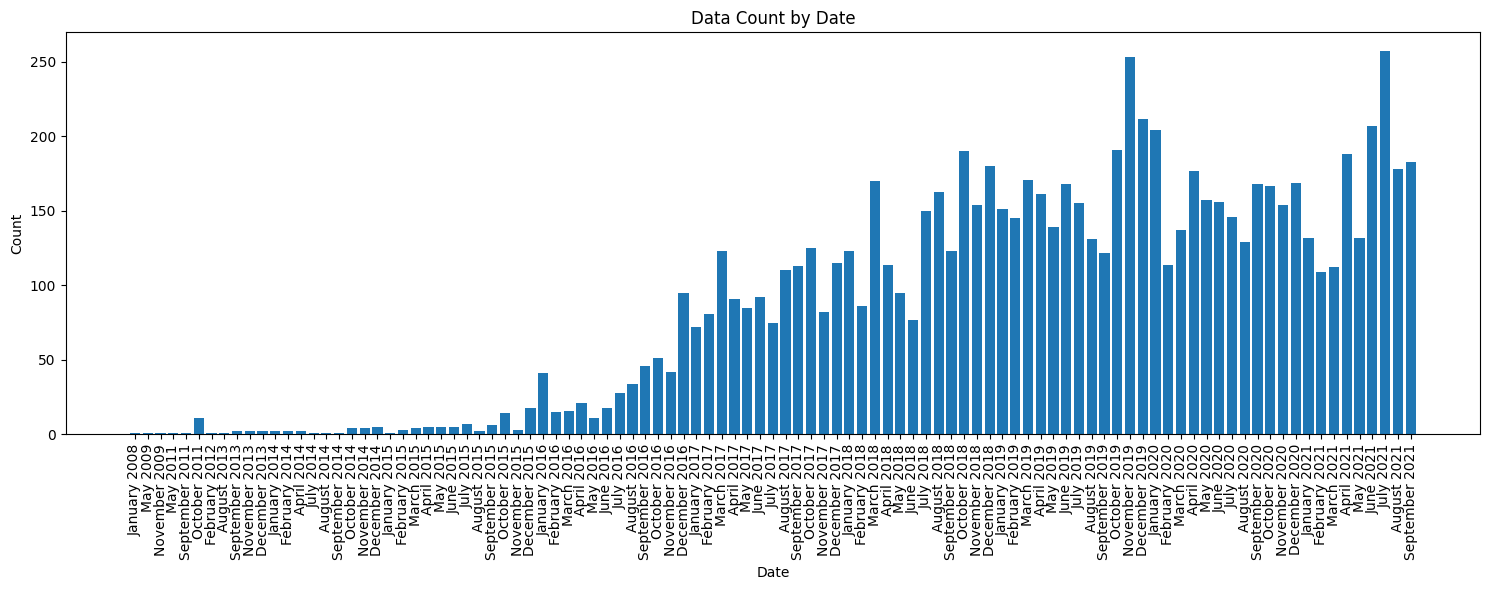

In [81]:
dates = list(date.keys())[:-15]
values = list(date.values())[:-15]

plt.figure(figsize=(15, 6))
plt.bar(dates[::-1], values[::-1])
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Data Count by Date')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [105]:
list(enumerate(dates[::-1]))

[(0, 'January 2008'),
 (1, 'May 2009'),
 (2, 'November 2009'),
 (3, 'May 2011'),
 (4, 'September 2011'),
 (5, 'October 2011'),
 (6, 'February 2012'),
 (7, 'August 2013'),
 (8, 'September 2013'),
 (9, 'November 2013'),
 (10, 'December 2013'),
 (11, 'January 2014'),
 (12, 'February 2014'),
 (13, 'April 2014'),
 (14, 'July 2014'),
 (15, 'August 2014'),
 (16, 'September 2014'),
 (17, 'October 2014'),
 (18, 'November 2014'),
 (19, 'December 2014'),
 (20, 'January 2015'),
 (21, 'February 2015'),
 (22, 'March 2015'),
 (23, 'April 2015'),
 (24, 'May 2015'),
 (25, 'June 2015'),
 (26, 'July 2015'),
 (27, 'August 2015'),
 (28, 'September 2015'),
 (29, 'October 2015'),
 (30, 'November 2015'),
 (31, 'December 2015'),
 (32, 'January 2016'),
 (33, 'February 2016'),
 (34, 'March 2016'),
 (35, 'April 2016'),
 (36, 'May 2016'),
 (37, 'June 2016'),
 (38, 'July 2016'),
 (39, 'August 2016'),
 (40, 'September 2016'),
 (41, 'October 2016'),
 (42, 'November 2016'),
 (43, 'December 2016'),
 (44, 'January 2017'

In [88]:
'November 2015'[-4:]

'2015'

In [92]:
'November 2015'.split(' ')[1]

'2015'

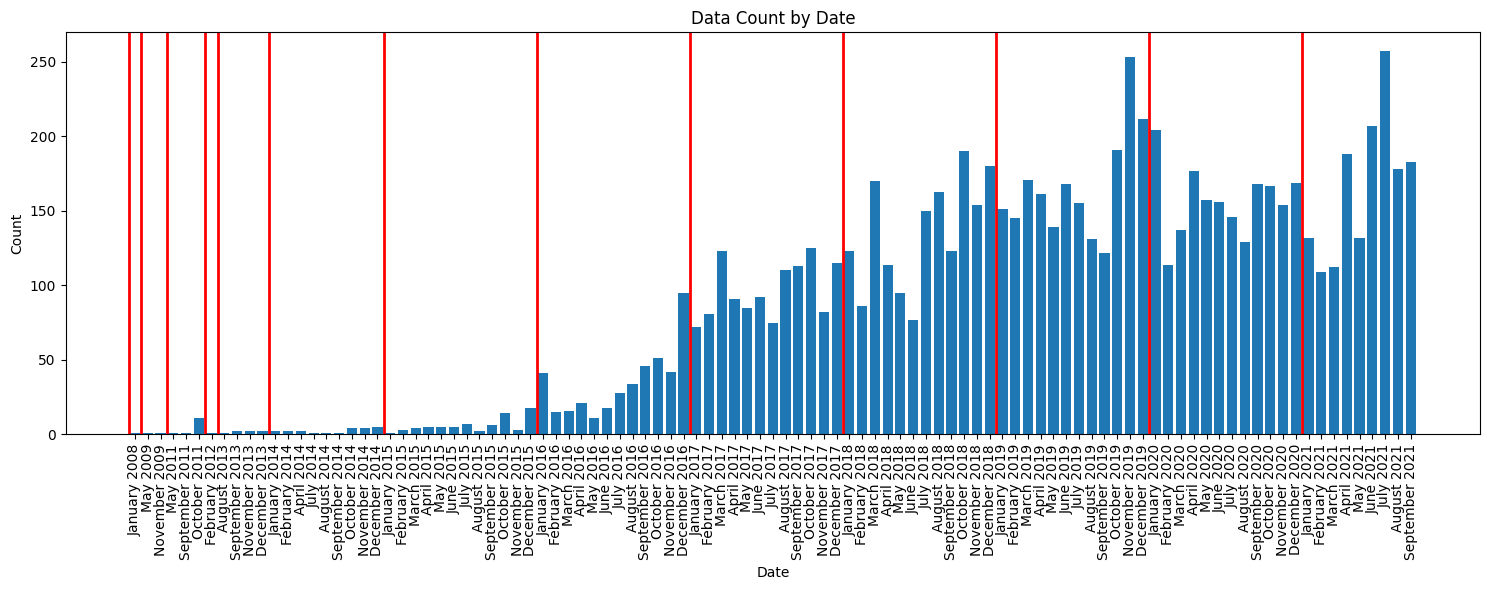

In [112]:
dates = list(date.keys())[:-15]
values = list(date.values())[:-15]

plt.figure(figsize=(15, 6))
plt.bar(dates[::-1], values[::-1])

plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Data Count by Date')
plt.xticks(rotation=90)

# Adding division lines for each new year
prev_year = 2008
for i, Date in enumerate(dates[::-1]):
  year = Date.split(' ')[1]
  if year != prev_year:
    plt.axvline(x=i-.5, color='red', linestyle='-', linewidth=2)
    prev_year = year

plt.tight_layout()
plt.show()

## Date added per movie and TV Shows

In [128]:
date_added_Movies, date_added_TV_shows = [], []
for i in range(len(df)):
  if df['type'].iloc[i] == 'Movie' and isinstance(df['date_added'].iloc[i], str):
    try:
      date_added_Movies.append(df['date_added'].iloc[i].split(' ')[0] + df['date_added'].iloc[i].split(',')[1][-5:])
    except:
      pass
  elif df['type'].iloc[i] == 'TV Show' and isinstance(df['date_added'].iloc[i], str):
    try:
      date_added_TV_shows.append(df['date_added'].iloc[i].split(' ')[0] + df['date_added'].iloc[i].split(',')[1][-5:])
    except:
      pass

In [131]:
count_date_added_Movies, count_date_added_TV_shows = Counter(date_added_Movies), Counter(date_added_TV_shows)

### plot

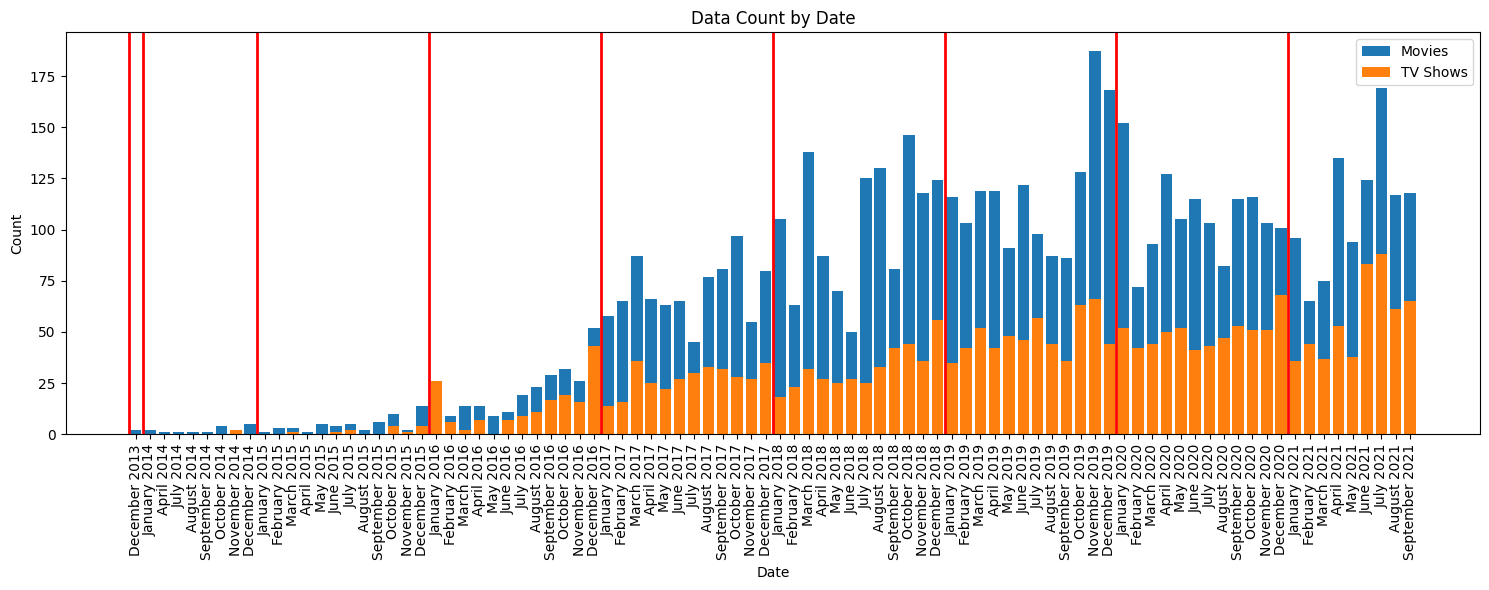

In [137]:
dates_movies = list(count_date_added_Movies.keys())[:-15]
values_movies = list(count_date_added_Movies.values())[:-15]
dates_TVShows = list(count_date_added_TV_shows.keys())[:-17]
values_TVShows = list(count_date_added_TV_shows.values())[:-17]

plt.figure(figsize=(15, 6))
plt.bar(dates_movies[::-1], values_movies[::-1], label = 'Movies')
plt.bar(dates_TVShows[::-1], values_TVShows[::-1], label = 'TV Shows')


plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Data Count by Date')
plt.xticks(rotation=90)

# Adding division lines for each new year
prev_year = 2008
for i, Date in enumerate(dates_movies[::-1]):
  year = Date.split(' ')[1]
  if year != prev_year:
    plt.axvline(x=i-.5, color='red', linestyle='-', linewidth=2)
    prev_year = year
plt.legend()
plt.tight_layout()
plt.show()

## release_year

In [24]:
release_year = df['release_year']
release_year = Counter(release_year)
release_year

Counter({2020: 953,
         2021: 592,
         1993: 28,
         2018: 1147,
         1996: 24,
         1998: 36,
         1997: 38,
         2010: 194,
         2013: 288,
         2017: 1032,
         1975: 7,
         1978: 7,
         1983: 11,
         1987: 8,
         2012: 237,
         2001: 45,
         2014: 352,
         2002: 51,
         2003: 61,
         2004: 64,
         2011: 185,
         2008: 136,
         2009: 152,
         2007: 88,
         2005: 80,
         2006: 96,
         1994: 22,
         2015: 560,
         2019: 1030,
         2016: 902,
         1982: 17,
         1989: 16,
         1990: 22,
         1991: 17,
         1999: 39,
         1986: 13,
         1992: 23,
         1984: 12,
         1980: 11,
         1961: 1,
         2000: 37,
         1995: 25,
         1985: 10,
         1976: 9,
         1959: 1,
         1988: 18,
         1981: 13,
         1972: 5,
         1964: 2,
         1945: 4,
         1954: 2,
         1979: 11,
     

In [25]:
release_year = dict(sorted(release_year.items(), reverse=True))
release_year

{2021: 592,
 2020: 953,
 2019: 1030,
 2018: 1147,
 2017: 1032,
 2016: 902,
 2015: 560,
 2014: 352,
 2013: 288,
 2012: 237,
 2011: 185,
 2010: 194,
 2009: 152,
 2008: 136,
 2007: 88,
 2006: 96,
 2005: 80,
 2004: 64,
 2003: 61,
 2002: 51,
 2001: 45,
 2000: 37,
 1999: 39,
 1998: 36,
 1997: 38,
 1996: 24,
 1995: 25,
 1994: 22,
 1993: 28,
 1992: 23,
 1991: 17,
 1990: 22,
 1989: 16,
 1988: 18,
 1987: 8,
 1986: 13,
 1985: 10,
 1984: 12,
 1983: 11,
 1982: 17,
 1981: 13,
 1980: 11,
 1979: 11,
 1978: 7,
 1977: 7,
 1976: 9,
 1975: 7,
 1974: 7,
 1973: 10,
 1972: 5,
 1971: 5,
 1970: 2,
 1969: 2,
 1968: 3,
 1967: 5,
 1966: 1,
 1965: 2,
 1964: 2,
 1963: 2,
 1962: 3,
 1961: 1,
 1960: 4,
 1959: 1,
 1958: 3,
 1956: 2,
 1955: 3,
 1954: 2,
 1947: 1,
 1946: 2,
 1945: 4,
 1944: 3,
 1943: 3,
 1942: 2,
 1925: 1}

### plot release year

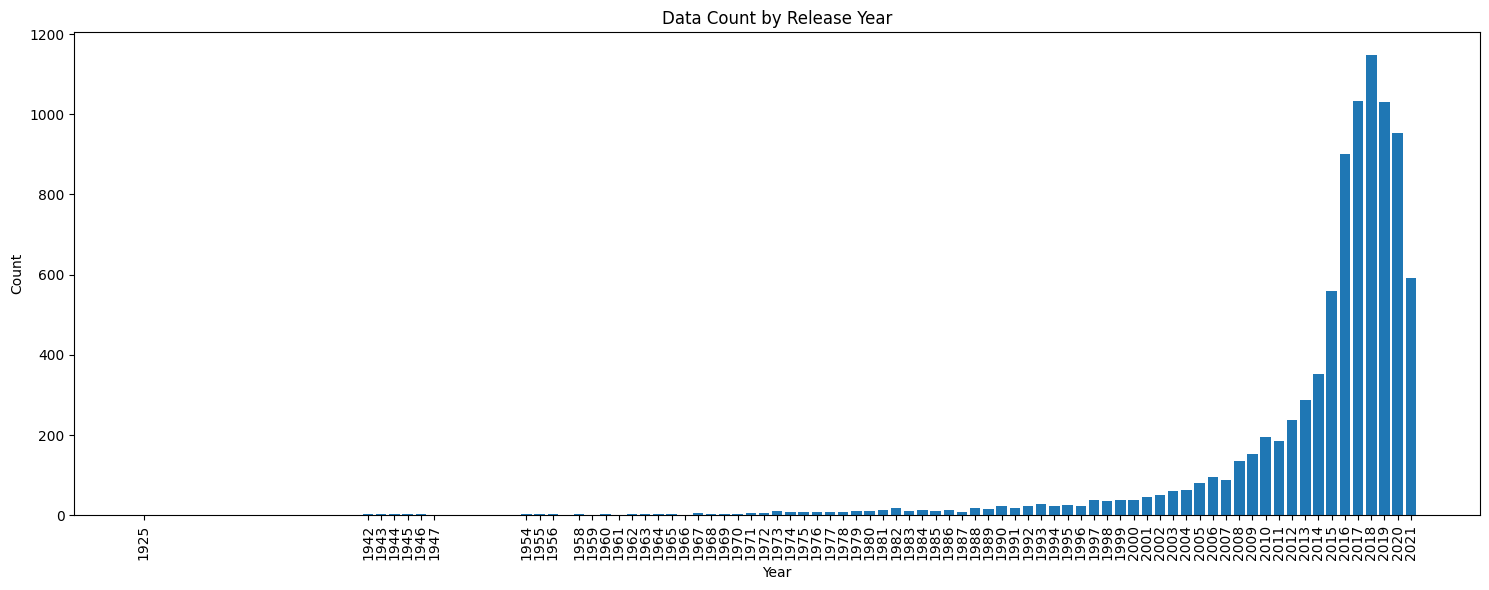

In [26]:
dates = list(release_year.keys())
values = list(release_year.values())

plt.figure(figsize=(15, 6))
plt.bar(dates[::-1], values[::-1])
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Data Count by Release Year')
plt.xticks(dates, rotation=90)
#plt.xticks(range(0, 36, 1), rotation=90)
plt.tight_layout()
plt.show()

## rating (classification)

In [27]:
df['rating']

0       PG-13
1       TV-MA
2       TV-MA
3       TV-MA
4       TV-MA
        ...  
8802        R
8803    TV-Y7
8804        R
8805       PG
8806    TV-14
Name: rating, Length: 8807, dtype: object

In [28]:
rating = df['rating'].value_counts()
rating

TV-MA       3207
TV-14       2160
TV-PG        863
R            799
PG-13        490
TV-Y7        334
TV-Y         307
PG           287
TV-G         220
NR            80
G             41
TV-Y7-FV       6
NC-17          3
UR             3
74 min         1
84 min         1
66 min         1
Name: rating, dtype: int64

In [29]:
labels = [rating.index[i] +': ' + str(rating[i]) for i in range(len(rating))]
labels

['TV-MA: 3207',
 'TV-14: 2160',
 'TV-PG: 863',
 'R: 799',
 'PG-13: 490',
 'TV-Y7: 334',
 'TV-Y: 307',
 'PG: 287',
 'TV-G: 220',
 'NR: 80',
 'G: 41',
 'TV-Y7-FV: 6',
 'NC-17: 3',
 'UR: 3',
 '74 min: 1',
 '84 min: 1',
 '66 min: 1']

### plot rating (classificaction)

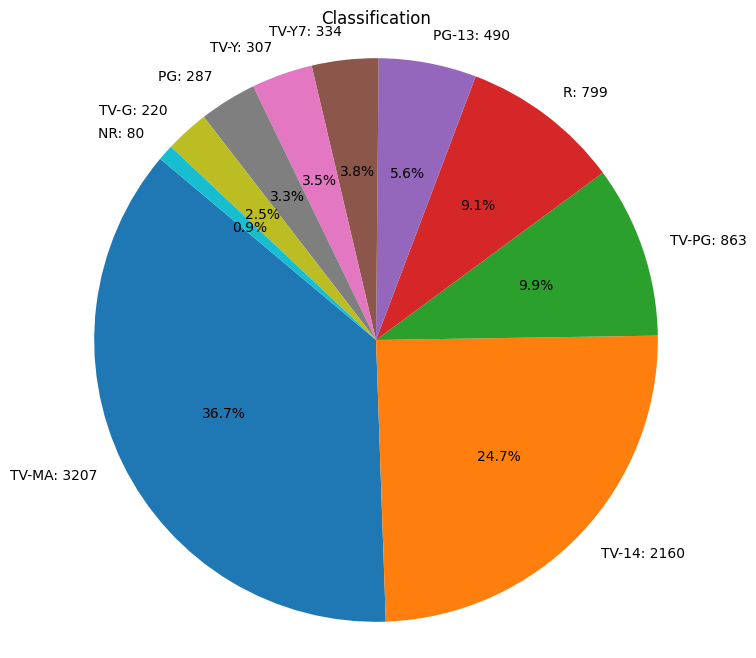

In [30]:
plt.figure(figsize=(8, 8))
plt.pie(rating[:-7], labels=labels[:-7],
        autopct='%1.1f%%',
        startangle=140)
plt.title('Classification')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

## duration

In [31]:
df['duration']

0          90 min
1       2 Seasons
2        1 Season
3        1 Season
4       2 Seasons
          ...    
8802      158 min
8803    2 Seasons
8804       88 min
8805       88 min
8806      111 min
Name: duration, Length: 8807, dtype: object

In [154]:
duration_TV_shows = []
duration_movies = []

In [147]:
#df['duration'].iloc[0][:-4]
import re
re.search('(\d+)', df['duration'].iloc[0]).group(1)

'90'

In [148]:
df['duration'].iloc[1][:-8]
re.search('(\d+)', df['duration'].iloc[1]).group(1)

'2'

In [155]:
for i in range(len(df)):
  if df['type'].iloc[i] == 'Movie':
    try:
      duration_movies.append(int(re.search('(\d+)', df['duration'].iloc[i]).group(1)))
    except:
      pass
  elif df['type'].iloc[i] == 'TV Show':
    try:
      duration_TV_shows.append(int(re.search('(\d+)', df['duration'].iloc[i]).group(1)))
    except:
      pass

In [156]:
duration_TV_shows_counter = Counter(duration_TV_shows)
duration_TV_shows_counter

Counter({2: 425,
         1: 1793,
         9: 9,
         4: 95,
         5: 65,
         3: 199,
         6: 33,
         7: 23,
         10: 7,
         8: 17,
         17: 1,
         13: 3,
         15: 2,
         12: 2,
         11: 2})

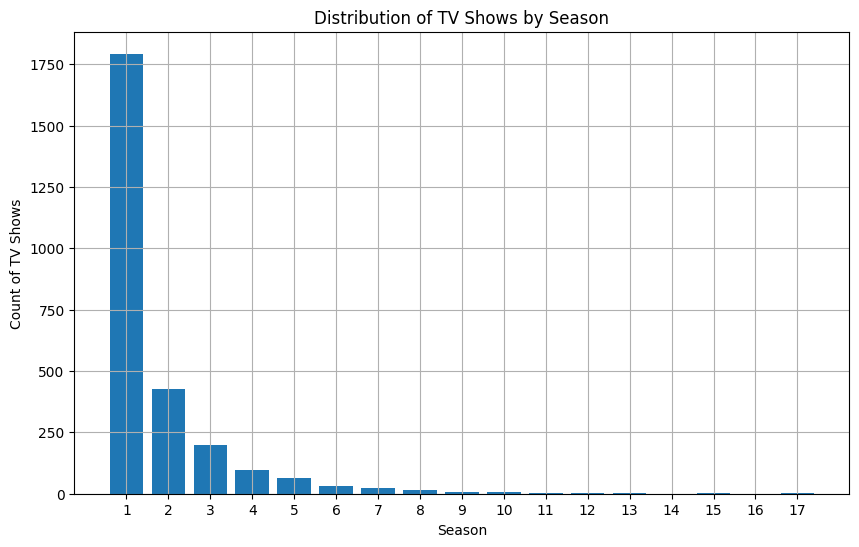

In [194]:
import matplotlib.pyplot as plt

data = duration_TV_shows_counter

# Create a list of counts for each season (filling in zeros for missing data)
counts = [data.get(season, 0) for season in range(1, 18)]

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar(range(1, 18), counts)
plt.xlabel('Season')
plt.ylabel('Count of TV Shows')
plt.title('Distribution of TV Shows by Season')
plt.grid(True)
plt.xticks(range(1, 18))
plt.show()


In [ ]:
duration_movies_counter = Counter(duration_movies)
duration_movies_counter

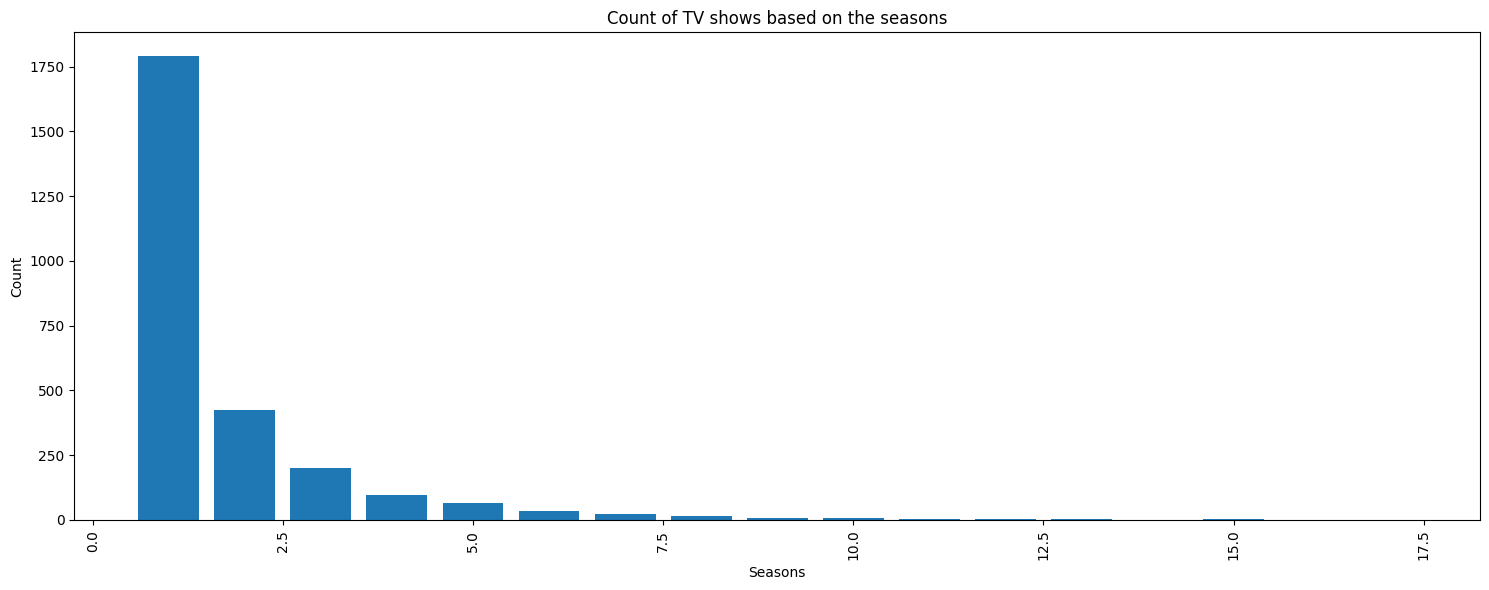

In [158]:
dates = list(duration_TV_shows_counter.keys())
values = list(duration_TV_shows_counter.values())

plt.figure(figsize=(15, 6))
plt.bar(dates, values)
plt.xlabel('Seasons')
plt.ylabel('Count')
plt.title('Count of TV shows based on the seasons')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

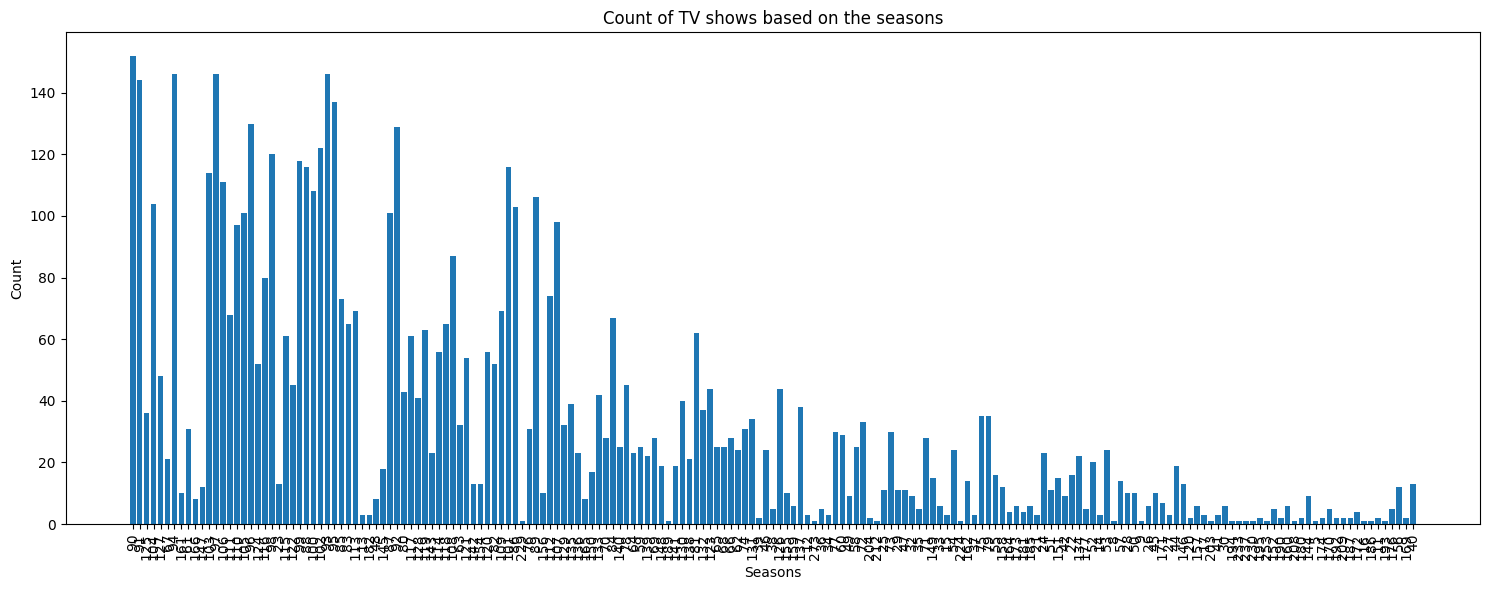

In [39]:
dates = list(duration_movies_counter.keys())[:-20]
values = list(duration_movies_counter.values())[:-20]

plt.figure(figsize=(15, 6))
plt.bar(dates, values)
plt.xlabel('Seasons')
plt.ylabel('Count')
plt.title('Count of TV shows based on the seasons')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [40]:
duration_movies_sorted = dict(sorted(duration_movies.items()))
duration_movies_sorted

AttributeError: 'list' object has no attribute 'items'

In [ ]:
duration_movies

In [ ]:
dict(sorted(duration_movies_counter.items()))

In [43]:
duration_movies = [int(x) for x in duration_movies]
duration_TV_shows = [int(x) for x in duration_TV_shows if x != '']

In [ ]:
duration_TV_shows

### plot duration movies

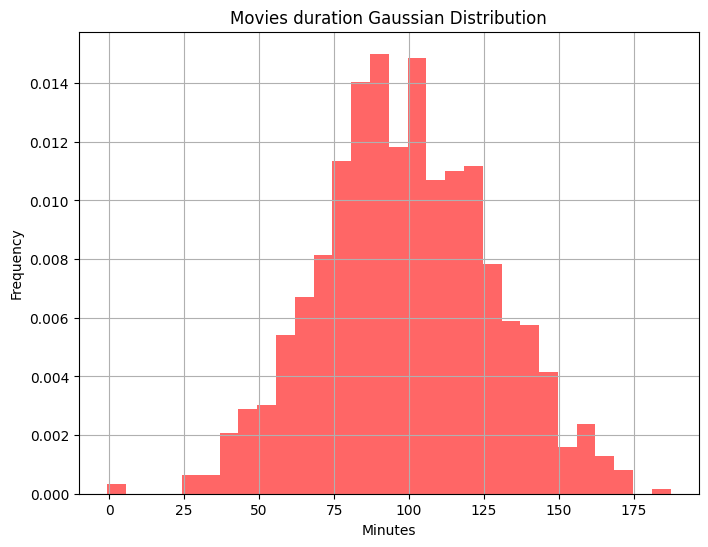

In [159]:
data = duration_movies

# Calculate mean and standard deviation of the data
mean = np.mean(data)
std_dev = np.std(data)

# Generate random samples from a Gaussian distribution
gaussian_samples = np.random.normal(mean, std_dev, 1000)

# Plotting the Gaussian distribution
plt.figure(figsize=(8, 6))
plt.hist(gaussian_samples, bins=30, density=True, alpha=0.6, color='r')
plt.title('Movies duration Gaussian Distribution')
plt.xlabel('Minutes')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### plot duration tv shows

In [140]:
duration_TV_shows.sort()

In [143]:
len(duration_TV_shows)

883

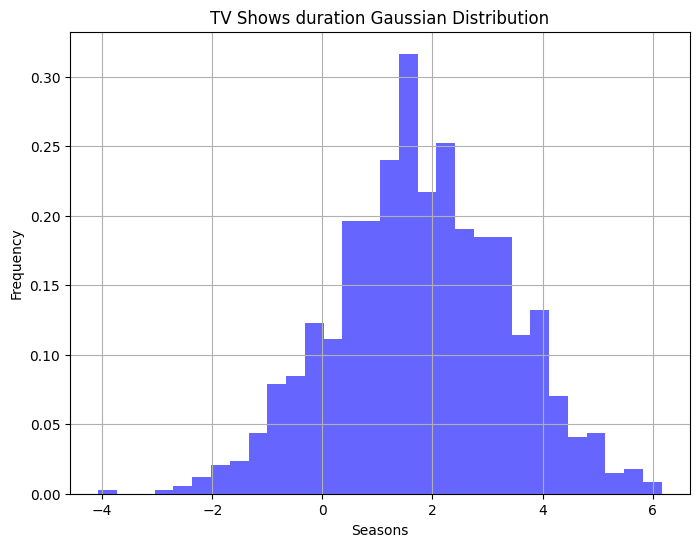

In [164]:
data = duration_TV_shows

# Calculate mean and standard deviation of the data
mean = np.mean(data)
std_dev = np.std(data)

# Generate random samples from a Gaussian distribution
gaussian_samples = np.random.normal(mean, std_dev, 1000)

# Plotting the Gaussian distribution
plt.figure(figsize=(8, 6))
plt.hist(gaussian_samples, bins=30, density=True, alpha=0.6, color='b')
plt.title('TV Shows duration Gaussian Distribution')
plt.xlabel('Seasons')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [162]:
import plotly.graph_objs as go
import numpy as np

# Example array of data
data_array = duration_TV_shows

# Create histogram
histogram = go.Histogram(x=data_array, histnorm='probability')

# Create layout
layout = go.Layout(
    title='Gaussian Distribution',
    xaxis=dict(title='Value'),
    yaxis=dict(title='Probability')
)

# Create figure
fig = go.Figure(data=[histogram], layout=layout)

# Show plot
fig.show()


In [171]:
seasons

[2, 1, 9, 4, 5, 3, 6, 7, 10, 8, 17, 13, 15, 12, 11]

In [172]:
counts

[425, 1793, 9, 95, 65, 199, 33, 23, 7, 17, 1, 3, 2, 2, 2]

In [178]:
list(range(min(seasons), max(seasons)+1))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

In [184]:
import plotly.graph_objs as go

data = Counter(duration_TV_shows)

# Create a list of all seasons
all_seasons = list(range(1, max(data.keys()) + 1))

# Create a list of counts for all seasons, filling in 0 for missing data
counts = [data.get(season, 0) for season in all_seasons]

# Create bar chart
bar_chart = go.Bar(x=all_seasons, y=counts)

# Create layout
layout = go.Layout(
    title='TV Shows by Season',
    #xaxis=dict(title='Season', tickmode='array', tickvals=all_seasons),
    xaxis=dict(title='Season', tickmode='array', tickvals=all_seasons, tickangle=-90),
    yaxis=dict(title='Number of TV Shows')
)

# Create figure
fig = go.Figure(data=[bar_chart], layout=layout)

# Show plot
fig.show()

In [195]:
data = Counter(duration_movies)

# Create a list of all seasons
all_seasons = list(range(1, max(data.keys()) + 1))

# Create a list of counts for all seasons, filling in 0 for missing data
counts = [data.get(season, 0) for season in all_seasons]

# Create bar chart
bar_chart = go.Bar(x=all_seasons, y=counts)

# Create layout
layout = go.Layout(
    title='Movies duration in minutes',
    #xaxis=dict(title='Season', tickmode='array', tickvals=all_seasons),
    xaxis=dict(title='Minutes', tickmode='array', tickvals=all_seasons, tickangle=-90, tickfont=dict(size=5)),
    yaxis=dict(title='Movies')
)

# Create figure
fig = go.Figure(data=[bar_chart], layout=layout)

# Show plot
fig.show()

In [161]:
import plotly.graph_objects as go

# Sample data
data = duration_TV_shows

# Create histogram
fig = go.Figure(data=[go.Histogram(x=data)])

# Update layout
fig.update_layout(
    title="Histogram",
    xaxis_title="Value",
    yaxis_title="Frequency"
)

# Show plot
fig.show()


## listed_in (category)

In [46]:
category = df['listed_in']
category

0                                           Documentaries
1         International TV Shows, TV Dramas, TV Mysteries
2       Crime TV Shows, International TV Shows, TV Act...
3                                  Docuseries, Reality TV
4       International TV Shows, Romantic TV Shows, TV ...
                              ...                        
8802                       Cult Movies, Dramas, Thrillers
8803               Kids' TV, Korean TV Shows, TV Comedies
8804                              Comedies, Horror Movies
8805                   Children & Family Movies, Comedies
8806       Dramas, International Movies, Music & Musicals
Name: listed_in, Length: 8807, dtype: object

In [47]:
category = [c.split(', ') for c in category if isinstance(c, str)]
category[:2]

[['Documentaries'], ['International TV Shows', 'TV Dramas', 'TV Mysteries']]

In [48]:
total_category = []
for c in category:
  total_category.extend(c)
total_category[:28]

['Documentaries',
 'International TV Shows',
 'TV Dramas',
 'TV Mysteries',
 'Crime TV Shows',
 'International TV Shows',
 'TV Action & Adventure',
 'Docuseries',
 'Reality TV',
 'International TV Shows',
 'Romantic TV Shows',
 'TV Comedies',
 'TV Dramas',
 'TV Horror',
 'TV Mysteries',
 'Children & Family Movies',
 'Dramas',
 'Independent Movies',
 'International Movies',
 'British TV Shows',
 'Reality TV',
 'Comedies',
 'Dramas',
 'Crime TV Shows',
 'Docuseries',
 'International TV Shows',
 'Crime TV Shows',
 'International TV Shows']

In [ ]:
sorted(Counter(total_category).items(), key=lambda x: x[1], reverse=True)

In [ ]:
total_category = [elem.replace(' ', '') for elem in total_category]
total_category

In [78]:
counts_category = sorted(Counter(total_category).items(), key=lambda x: x[1], reverse=True)
counts_category

[('InternationalMovies', 2752),
 ('Dramas', 2427),
 ('Comedies', 1674),
 ('InternationalTVShows', 1351),
 ('Documentaries', 869),
 ('Action&Adventure', 859),
 ('TVDramas', 763),
 ('IndependentMovies', 756),
 ('Children&FamilyMovies', 641),
 ('RomanticMovies', 616),
 ('TVComedies', 581),
 ('Thrillers', 577),
 ('CrimeTVShows', 470),
 ("Kids'TV", 451),
 ('Docuseries', 395),
 ('Music&Musicals', 375),
 ('RomanticTVShows', 370),
 ('HorrorMovies', 357),
 ('Stand-UpComedy', 343),
 ('RealityTV', 255),
 ('BritishTVShows', 253),
 ('Sci-Fi&Fantasy', 243),
 ('SportsMovies', 219),
 ('AnimeSeries', 176),
 ('Spanish-LanguageTVShows', 174),
 ('TVAction&Adventure', 168),
 ('KoreanTVShows', 151),
 ('ClassicMovies', 116),
 ('LGBTQMovies', 102),
 ('TVMysteries', 98),
 ('Science&NatureTV', 92),
 ('TVSci-Fi&Fantasy', 84),
 ('TVHorror', 75),
 ('AnimeFeatures', 71),
 ('CultMovies', 71),
 ('TeenTVShows', 69),
 ('Faith&Spirituality', 65),
 ('TVThrillers', 57),
 ('Movies', 57),
 ('Stand-UpComedy&TalkShows', 56),


### Wordcloud plot

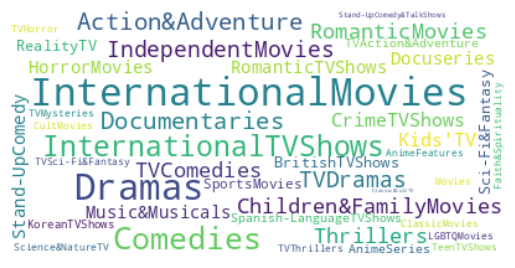

In [77]:
word_list = total_category

# Join the words into a single string separated by spaces
text = ' '.join(word_list)

# Generate a word cloud
wordcloud = WordCloud(background_color='white', max_words  = 42).generate_from_frequencies(Counter(total_category))

# Display the word cloud using matplotlib
plt.figure()#figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()